In [167]:
import numpy as np
import pandas as pd

1. load the file
2. create universe dataframe
3. create buy sell signal
4. price all options

In [168]:
df_spx=pd.read_csv('SPX.csv')  
df_spx['date']=pd.to_datetime(df_spx['date'])
df_spx.index=df_spx['date']
df_spx=df_spx.sort_index()

In [179]:
df_bvols=pd.read_excel('bloomberg_spx_vols_values.xlsx', index_col=0) 
#df_bvols['Date']=pd.to_datetime(df_bvols['Date'])
#df_bvols.index=df_bvols['date']
#df_bvols=df_bvols.sort_index()
df_bvols=df_bvols['2005-05-18':]
df_bvols

,px,12m atm vol,24m atm vol,12m slope,24m slope
date,,,,,
2005-05-18,1185.56,14.7994,16.1761,-0.830764,-2.561531
2005-05-19,1191.08,14.4530,15.7034,-0.832010,-2.310149
2005-05-20,1189.28,14.3018,15.6604,-0.847508,-2.447997
2005-05-23,1193.86,14.0931,15.3672,-0.861660,-2.837509
2005-05-24,1194.07,14.0674,15.4045,-0.840980,-2.289923
...,...,...,...,...,...
2020-10-15,3483.34,22.2533,21.6859,-3.730241,-3.464660
2020-10-16,3483.81,22.5848,21.8534,-3.816402,-3.597786
2020-10-19,3426.92,23.4197,22.4914,-3.765921,-3.487846


In [180]:
pct_strikes=np.array([0.85,1,1,1.15])
maturity_days=720
maturity_years=2
price_field="px"
vol12_field="12m atm vol"
vol24_field="24m atm vol"
slope12_field="12m slope"
slope24_field="24m slope"
spot_field="px"
df_bvols[vol12_field]=df_bvols[vol12_field]/100
df_bvols[vol24_field]=df_bvols[vol24_field]/100
df_bvols[slope12_field]=df_bvols[slope12_field]/100
df_bvols[slope24_field]=df_bvols[slope24_field]/100

df_bvols.replace(0, np.nan, inplace=True)
df_bvols=df_bvols.fillna(method='ffill')
df_option_universe=pd.DataFrame(index=df_bvols.index)
strikes_universe=[]
creation_dates_universe=[]
maturity_dates_universe=[]
pc_universe=[]

for ind, row in df_bvols.iterrows():
    strikes=pct_strikes*row[price_field]
    pc=['p']*2+['c']*2
    creation_dates=[ind]*4
    maturity_dates=[ind+pd.Timedelta(days=maturity_years*365)]*4
    maturity_dates=pd.to_datetime(maturity_dates)
    strikes_universe.extend(strikes)
    creation_dates_universe.extend(creation_dates)
    maturity_dates_universe.extend(maturity_dates)
    pc_universe.extend(pc)

    #df_option_universe.loc[ind,'strikes']=strikes
    
    #if ind.day==1:
    #    df_spx.loc[ind,'pct_strike']=pct_strikes[np.random.randint(0,4)]
    #    df_spx.loc[ind,'maturity_days']=maturity_days
    #    maturity_days+=90


# create grids of strikes, creation dates, maturity dates, and pc]

strikes_universe=np.array(strikes_universe)
creation_dates_universe=np.array(creation_dates_universe)
maturity_dates_universe=np.array(maturity_dates_universe)
pc_universe=np.array(pc_universe)

spot_array=df_bvols[spot_field].values

#create 2d grids of strikes, creation dates, maturity dates, and pc where one dimension is the index of bvols and the other is the index of the strike
strikes_grid=np.tile(strikes_universe, (len(df_bvols),1))
creation_dates_grid=np.tile(creation_dates_universe, (len(df_bvols),1))
#need to figure out whiy the following needed to be done (convert back to datetime)
maturity_dates_grid=np.tile(maturity_dates_universe, (len(df_bvols),1))
pc_grid=np.tile(pc_universe, (len(df_bvols),1))
spot_grid=np.tile(df_bvols[spot_field].values, (len(strikes_universe),1)).T
vol12_grid=np.tile(df_bvols[vol12_field].values, (len(strikes_universe),1)).T
vol24_grid=np.tile(df_bvols[vol24_field].values, (len(strikes_universe),1)).T
slope12_grid=np.tile(df_bvols[slope12_field].values, (len(strikes_universe),1)).T
slope24_grid=np.tile(df_bvols[slope24_field].values, (len(strikes_universe),1)).T
date_grid=np.tile(df_bvols.index.to_numpy(), (len(strikes_universe),1)).T

In [181]:
myfunc_vec = np.vectorize(lambda x: x.to_datetime64())
texp_grid=(myfunc_vec(maturity_dates_grid) -date_grid)/np.timedelta64(1, 'D')/365


In [182]:
texp_grid=np.where(texp_grid<0, np.nan, texp_grid)

In [183]:
from scipy import interpolate
#interp_date_grid, interp_term_grid=np.meshgrid(df_bvols.index, [1,2],indexing='ij')
#create a table of atm vols and slopes for each date.
#rows are dates, columns are terms
#then we can go row by row and interpolate the vols and slopes for each instrument maturit, then use the interpolated vols and slopes to calculate the vol of each instrument
ivols_for_interp=df_bvols[[vol12_field,vol12_field, vol24_field,vol24_field]].values
slops_for_interp=df_bvols[[slope12_field,slope12_field, slope24_field,slope24_field]].values
#vol_interp=interpolate.RegularGridInterpolator((interp_date_grid, interp_term_grid), ivols_for_interp, method='linear')
#interp_date_grid.shape

# using giant negative value for initial interp point, need to fix, so that we dont have terms below zero
interp_terms=np.array([-50000,1,2,10000])
strike_vol_grid=np.zeros_like(strikes_grid)
strike_slope_grid=np.zeros_like(strikes_grid)

term_vol_grid=np.zeros_like(strikes_grid)
term_slope_grid=np.zeros_like(strikes_grid)

for i in range(len(df_bvols)):
    vol_interp=interpolate.interp1d(interp_terms, ivols_for_interp[i,:], kind='linear')
    slop_interp=interpolate.interp1d(interp_terms, slops_for_interp[i,:], kind='linear')
    term_vol_grid[i,:]=vol_interp(texp_grid[i,:])
    term_slope_grid[i,:]=slop_interp(texp_grid[i,:])

#compute spot vols from term vols and slopes 
#spot_vol_grid=term_vol_grid+term_slope_grid*np.log(strikes_grid/spot_grid)*10/np.sqrt(texp_grid)
spot_vol_grid=np.where(texp_grid<=0, np.nan, term_vol_grid+term_slope_grid*np.log(strikes_grid/spot_grid)*10/np.sqrt(texp_grid))
spot_vol_grid

/var/folders/c1/dv7w7b2x49j3spqsxnz6y_sw0000gn/T/ipykernel_2915/3305075419.py:27: RuntimeWarning: divide by zero encountered in divide
  spot_vol_grid=np.where(texp_grid<=0, np.nan, term_vol_grid+term_slope_grid*np.log(strikes_grid/spot_grid)*10/np.sqrt(texp_grid))


array([[0.19119766, 0.161761  , 0.161761  , ..., 0.09649694, 0.09649694,
        0.08792389],
       [0.1842772 , 0.15775774, 0.15775774, ..., 0.09842716, 0.09842716,
        0.09069483],
       [0.18514029, 0.15707065, 0.15707065, ..., 0.09440651, 0.09440651,
        0.08621214],
       ...,
       [       nan,        nan,        nan, ..., 0.22429383, 0.22429383,
        0.18987175],
       [       nan,        nan,        nan, ..., 0.22423448, 0.22423448,
        0.18859732],
       [       nan,        nan,        nan, ..., 0.222671  , 0.222671  ,
        0.1883209 ]])

In [178]:
df_bvols

,px,12m atm vol,24m atm vol,12m slope,24m slope
date,,,,,
2005-05-18,1185.56,0.001480,0.001618,-0.000083,-0.000256
2005-05-19,1191.08,0.001445,0.001570,-0.000083,-0.000231
2005-05-20,1189.28,0.001430,0.001566,-0.000085,-0.000245
2005-05-23,1193.86,0.001409,0.001537,-0.000086,-0.000284
2005-05-24,1194.07,0.001407,0.001540,-0.000084,-0.000229
...,...,...,...,...,...
2020-10-15,3483.34,0.002225,0.002169,-0.000373,-0.000346
2020-10-16,3483.81,0.002258,0.002185,-0.000382,-0.000360
2020-10-19,3426.92,0.002342,0.002249,-0.000377,-0.000349


In [184]:
import py_vollib.black_scholes
import py_vollib_vectorized

In [185]:

price=py_vollib_vectorized.models.vectorized_black_scholes_merton(pc_grid.flatten(),spot_grid.flatten(),strikes_grid.flatten(),texp_grid.flatten(),0,spot_vol_grid.flatten(),0,return_as='array')
price=price.reshape(spot_grid.shape)
option_greeks = py_vollib_vectorized.get_all_greeks(pc_grid.flatten(), spot_grid, strikes_grid, texp_grid, 0, spot_vol_grid,0,model='black_scholes_merton', return_as='dict')


In [186]:
option_greeks={k: np.array(v).reshape(spot_grid.shape) for k, v in option_greeks.items()}


In [187]:

# do pl attribution
spot_lag_grid=np.roll(spot_grid,shift =1, axis=0)
spot_vol_lag_grid=np.roll(spot_vol_grid,shift =1, axis=0)
#texp_lag_grid=np.roll(texp_grid,shift =1, axis=0)
for grid in [spot_lag_grid,spot_vol_lag_grid]:
    grid[0,:]=np.nan

price_open=py_vollib_vectorized.models.vectorized_black_scholes_merton(pc_grid.flatten(),spot_lag_grid,strikes_grid,texp_grid,0,spot_vol_lag_grid.flatten(),0,return_as='array')
price_open=price_open.reshape(spot_grid.shape)
option_greeks_open=py_vollib_vectorized.get_all_greeks(pc_grid.flatten(), spot_lag_grid, strikes_grid, texp_grid, 0, spot_vol_lag_grid,0,model='black_scholes_merton', return_as='dict')
option_greeks_open={k: np.array(v).reshape(spot_grid.shape) for k, v in option_greeks_open.items()}
price_spot_move=py_vollib_vectorized.models.vectorized_black_scholes_merton(pc_grid.flatten(),spot_grid,strikes_grid,texp_grid,0,spot_vol_lag_grid,0,return_as='array')
price_spot_move=price_spot_move.reshape(spot_grid.shape)
spot_vol_lag_grid
#spot_grid.shape
#spot_grid
#grd

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.19119766, 0.161761  , 0.161761  , ..., 0.09649694, 0.09649694,
        0.08792389],
       [0.1842772 , 0.15775774, 0.15775774, ..., 0.09842716, 0.09842716,
        0.09069483],
       ...,
       [       nan,        nan,        nan, ..., 0.22206995, 0.22206995,
        0.18663539],
       [       nan,        nan,        nan, ..., 0.22429383, 0.22429383,
        0.18987175],
       [       nan,        nan,        nan, ..., 0.22423448, 0.22423448,
        0.18859732]])

1) start with today (date), spot,vol (t-1) =>price_open
2) date, spot, today vol (t-1) => prices_spot_move

In [188]:
price_lag=np.roll(price,shift =1, axis=0)
price_lag[0,:]=np.nan
pnl_theta_open=price_open-price_lag
pnl_spot=price_spot_move-price_open
pnl_vol=price-price_spot_move
#rename this to gamma
pnl_spot_dn=pnl_spot-option_greeks_open['delta']*(spot_grid-spot_lag_grid)

create the positions
for every day add options that were created on that day

In [189]:
#pre: creation_dates_universe has the list of dates for each option
#for each date take four options at a time, put a buy order
portfolio=np.zeros_like(texp_grid)
for i in range(len(df_bvols)):
    strikes=strikes_universe[i*4:(i+1)*4]
    vegas=option_greeks['vega'][i,i*4:(i+1)*4]
    deltas=option_greeks['delta'][i,i*4:(i+1)*4]
    #print(f'date: { df_bvols.index[i]} buy {strikes} at {vegas} deltas {deltas}')
 
    qty=[.5*vegas[1]/vegas[0],-.5,-.5,.5*vegas[2]/vegas[3]]/df_bvols[spot_field].values[i]
    
    d_sum=np.array(deltas)@np.array(qty)
    qty[1]=qty[1]+d_sum
    qty[2]=qty[2]-d_sum
    #see what effect not paying theta will have
    #qty=[.5,-.5,-.5,.5]/df_bvols[spot_field].values[i]
    #if(i>0):
    #    portfolio[i,:]=np.where(texp_grid[i,:]>.9,portfolio[i-1,:],0)


    #print(f'texp_grid[i,:]: {texp_grid[i,:]}')

    portfolio[i,i*4:(i+1)*4]=qty

portfolio



array([[ 0.00054967, -0.0004516 , -0.00039189, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.0001563 ,
        -0.00013477,  0.00015526]])

In [190]:
qty_lag=np.roll(portfolio,shift =1, axis=0)
qty_lag[0,:]=0
pnl_all=qty_lag*(price-price_lag)
pnl_delta_neutral=pnl_all-option_greeks_open['delta']*(spot_grid-spot_lag_grid)

pnl_attrib_vol=qty_lag*pnl_vol
pnl_attrib_spot=qty_lag*pnl_spot
pnl_attrib_theta=qty_lag*pnl_theta_open
pnl_attrib_spot_dn=qty_lag*pnl_spot_dn
#pnl_attrib_gamma=qty_lag*option_greeks_open['gamma']*(spot_grid-spot_lag_grid)**2
#pnl_attrib_vega=qty_lag*option_greeks_open['vega']*(spot_vol_grid-spot_vol_lag_grid)
#pnl_attrib_rho=qty_lag*option_greeks_open['rho']*(spot_grid-spot_lag_grid)*.01
#pnl_attrib_theta=qty_lag*pnl_theta_open



Text(0.5, 1.0, 'delta neutral spot')

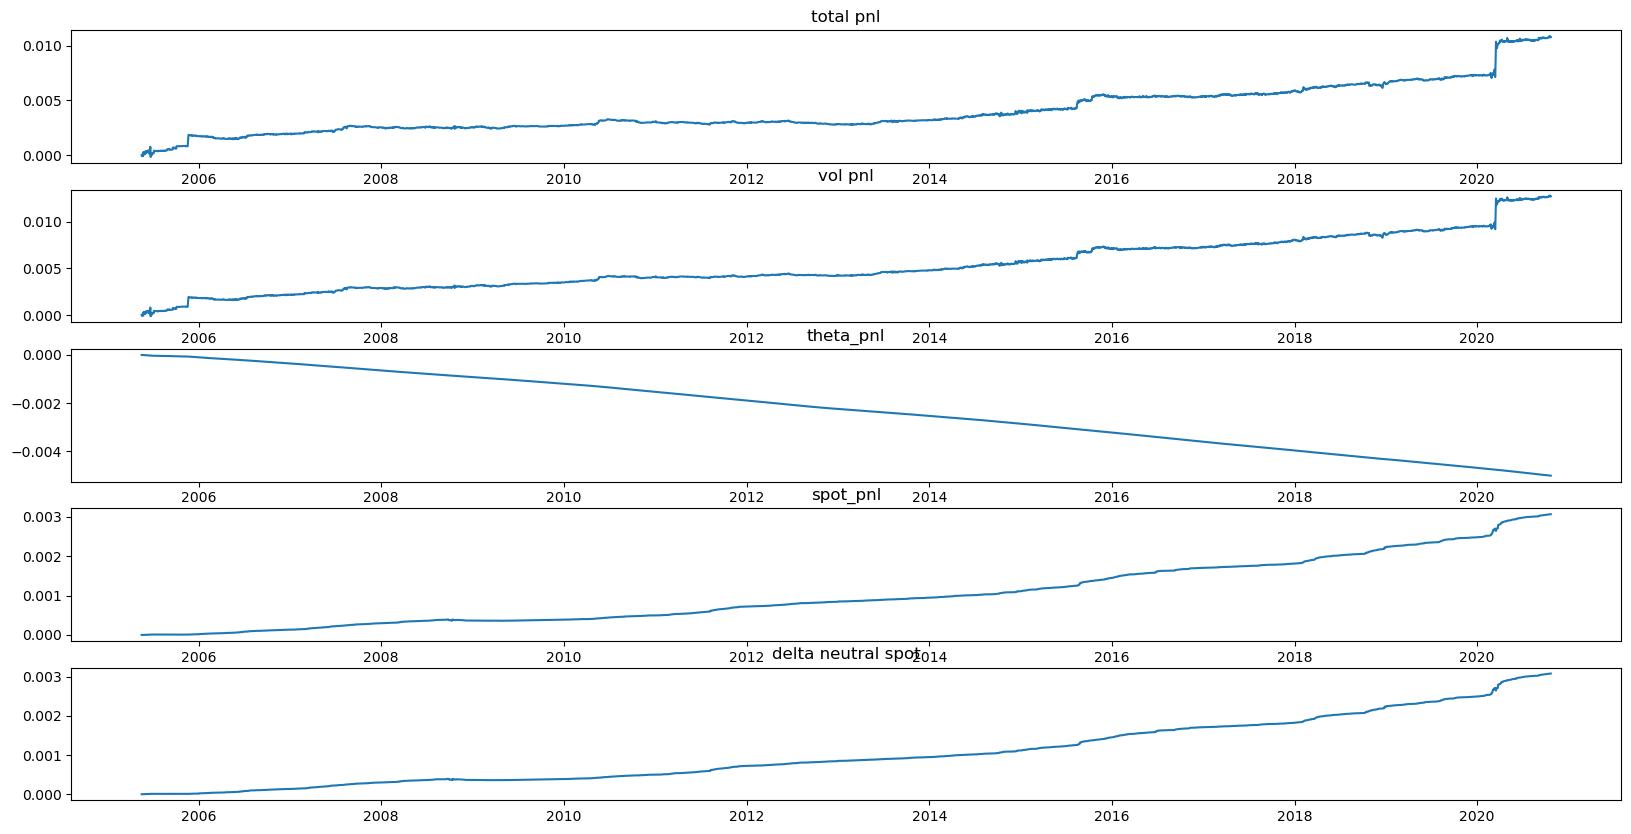

In [191]:
total_pnl=pnl_all.sum(axis=1)
import matplotlib.pyplot as plt
#plt.plot(df_bvols.index,total_pnl.cumsum())
pnl_all=np.where(qty_lag==0,0,pnl_all)
pnl_attrib_vol=np.where(qty_lag==0,0,pnl_attrib_vol)
pnl_attrib_theta=np.where(qty_lag==0,0,pnl_attrib_theta)
pnl_attrib_spot=np.where(qty_lag==0,0,pnl_attrib_spot)
pnl_attrib_spot_dn=np.where(qty_lag==0,0,pnl_attrib_spot_dn)
fig, ax= plt.subplots(5,1,figsize=(20, 10))
ax[0].plot(df_bvols.index,pnl_all.sum(axis=1).cumsum())
ax[1].plot(df_bvols.index,pnl_attrib_vol.sum(axis=1).cumsum())
ax[2].plot(df_bvols.index,pnl_attrib_theta.sum(axis=1).cumsum())
ax[3].plot(df_bvols.index,pnl_attrib_spot.sum(axis=1).cumsum())
ax[4].plot(df_bvols.index,pnl_attrib_spot_dn.sum(axis=1).cumsum())
ax[0].set_title('total pnl')    
ax[1].set_title('vol pnl') 
ax[2].set_title('theta_pnl')    
ax[3].set_title('spot_pnl') 
ax[4].set_title('delta neutral spot') 



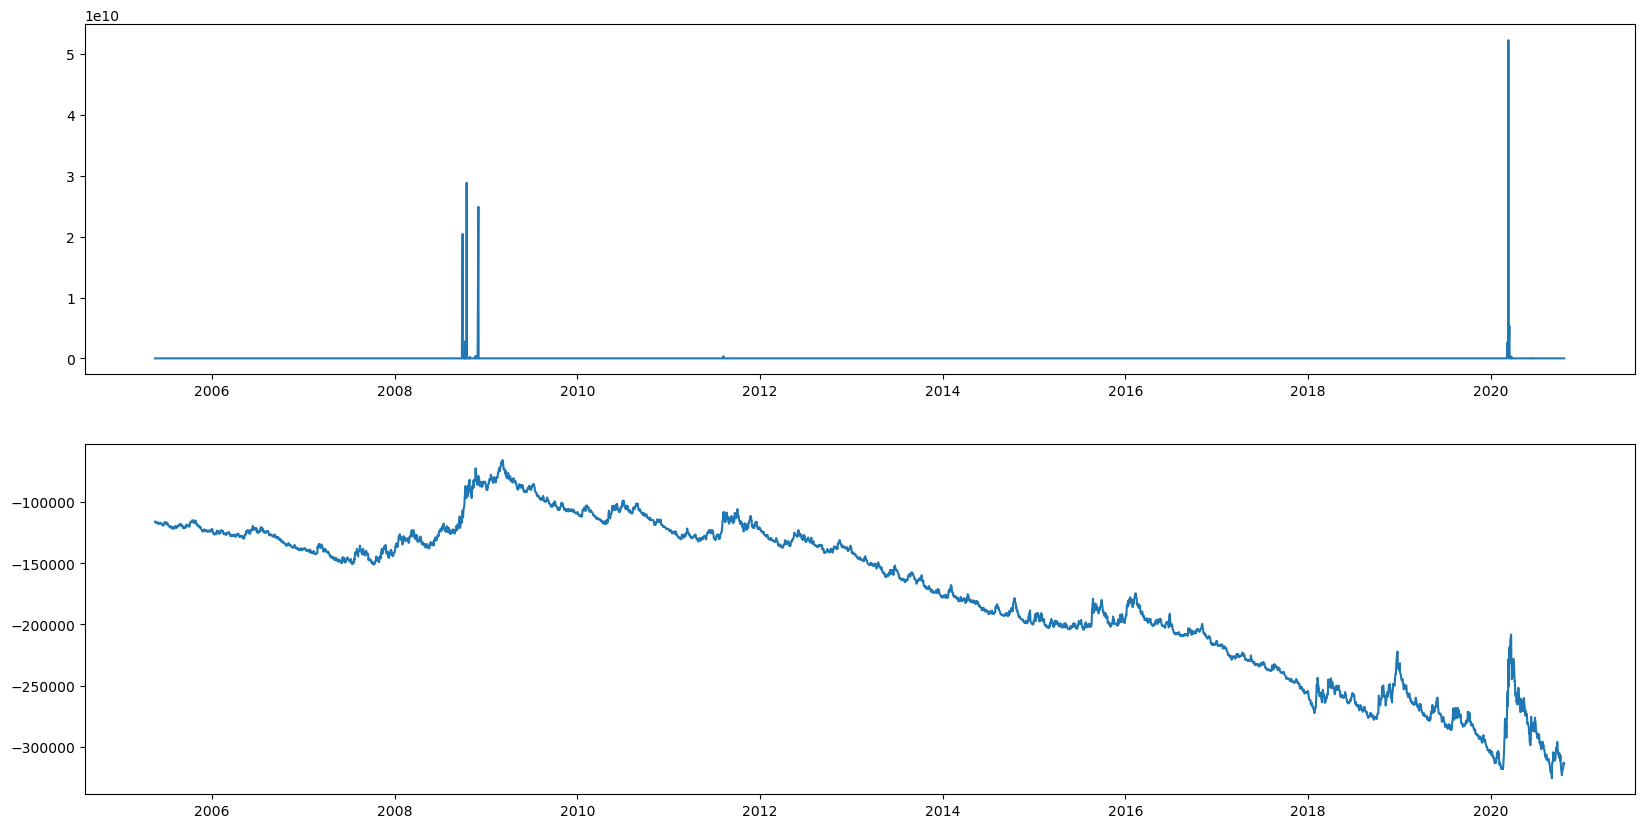

In [165]:
adj_vega=np.where(qty_lag==0,0,option_greeks["vega"])
vega_exp=adj_vega*qty_lag
fig, ax= plt.subplots(2,1,figsize=(20, 10))
ax[0].plot(df_bvols.index,vega_exp.sum(axis=1))
adj_gamma=np.where(portfolio==0,0,option_greeks["gamma"])

gamma_exp=adj_gamma*portfolio*spot_grid*spot_grid
ax[1].plot(df_bvols.index,gamma_exp.sum(axis=1))


In [16]:
#try interpolation
a=np.arange(1,10)
b=np.arange(1,5)

ag,bg=np.meshgrid(a,b,indexing='ij')
c=ag*ag+2*bg
c
d=interpolate.RegularGridInterpolator((a,b),c, method='linear')
d((ag,bg))


array([[ 3.,  5.,  7.,  9.],
       [ 6.,  8., 10., 12.],
       [11., 13., 15., 17.],
       [18., 20., 22., 24.],
       [27., 29., 31., 33.],
       [38., 40., 42., 44.],
       [51., 53., 55., 57.],
       [66., 68., 70., 72.],
       [83., 85., 87., 89.]])

In [116]:
option_greeks["gamma"][0,0:4]/100*spot_grid[0,0:4]*spot_grid[0,0:4]
#spot_grid[0,0:4]
#strikes_grid[0,0:4]
#spot_lag_grid[0:4,0]
#option_greeks["gamma"][0,0:4]
gamma_exp*spot_grid/100

array([[  8.69273684, -10.99706783,  -9.54308083, ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ..., -23.08381163,
        -19.90395696,  25.42348574]])

In [78]:
a=[-1,-1,0,2,2]
b=[1,2,3,4,5]
np.where(np.array(a)>0, np.array(b), np.nan)
a=1.46e-03


1460.0